In [2]:
import pde
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def zapisiM1(filename,comment=""):
    with open(filename, 'a') as file:
        file.write(f"{Tig},{cLFL}, {A},{C1},{C2},{T0},{c0},{q},{D0},{alpha0},{comment}\n")

In [4]:
grid = pde.CartesianGrid([[0,10]],100,periodic=True) #inicijalizacija domene

In [5]:
pobuda = pde.ScalarField.from_expression(grid, '0*exp(-(x-0.5)**2/0.001)') #upaljac

In [272]:
def alpha(x): #thermal diffusivity
    return alpha0
def D(x): #mass diffusivity
    return D0
def r(T,c): #stopa reakcije
    x = np.array([T,c]).T
    return np.piecewise(x, [np.logical_and(x[:,0] > 0, x[:,1] > cLFL)], [A,0], A0,Ea,a,b)[:,0]
    #return np.piecewise(x, [np.logical_and(x[:,0] > Tig, x[:,1] > cLFL)], [A(c0,A0,Ea,1000,a,b),0])[:,0]
def h(T): #heat loss
    return C1*(T-T0)
def e(T,c): #isparavanje + gubitci 
    return (c0-c)*C2
def q(x):
    return qc/rho/cp
def upaljac(x,t):
    return 0 
    if t>0.5: return 0
    return 50000*np.exp(-(x-5)**2/0.01)

## Model 1
$$ \partial_t T= \alpha \partial_x^2T +qr-h$$ $$\partial_t c = D \partial_x^2 c -r+e$$
$$ r(T,c) = \begin{array}{cc}
  \Bigg \{ & 
    \begin{array}{cc}
      A ,& T>T_{\mathrm{ig}} \wedge c>c_{\mathrm{LFL}} \\
      0 ,& \mathrm{otherwise} \\
    \end{array}
\end{array}$$
$$ h(T) =C_1(T-T_0)$$
$$ e(T,c) = C_2(c_0-c)$$

In [157]:
Tig = 10 #ignition temperature
cLFL = 0.1  #lower flammability limit koncentracija
A = 50 #stopa izgaranja
C1 = 2 #heat transfer coefficient
C2 = 0.1 #1/(karakteristicno vrijeme difuzije para) 
T0 = 1 #ambientalna temperatura
c0 = 1 #saturacijska koncentracija para
qc = 100
D0 = 0.1
alpha0 = 0.1

In [273]:
def A(x, A0, Ea, a, b):
    R = 1.987
    o2 = 8.8e-6
    rez = A0*np.exp(-Ea/(1.987*x[:,0]))*(x[:,1]**a)*(o2**b)
    return np.array([rez,rez]).T

In [274]:
Tig = 636 #K
cLFL = 1.24e-6 #mol/cm^3 #3.3%vol

A0 = 1.5e12
#A0 = 1.5e14
Ea = 30000 #cal/mol
a = 0.15
b = 1.6

H = 0.5#cm
C1 = 1.5/H #1/s
D0 = 0.17 #cm^2/s
C2 = D0/(2*H)**2 #(D0 = difuzijska konstanta etanola, h = visina plamena u cm)
C2 = 1

T0 = 300 #K
c0 = 11.3e-6 #mol/cc
qc = 1336.8e3 #J/mol
#qc = 1336.8e5 #J/mol
rho = 0.76 #g/bcc
cp = 3 #J/gK


alpha0 = 3 #cm^2/s

In [275]:
1/C1 #t_term

0.3333333333333333

In [279]:
1/C2 #t_evap

1.0

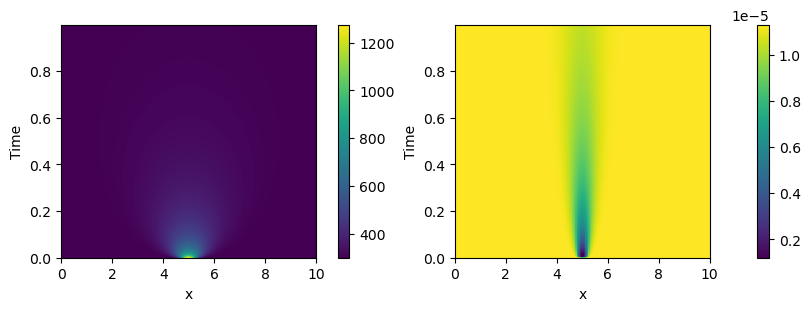

In [280]:
Tinit = pde.ScalarField(grid, T0) + pobuda #pocetna temperatura
cinit = pde.ScalarField(grid, c0) + 0*pobudaC#pocetna koncentracija
init = pde.FieldCollection([Tinit,cinit])

#definicija sustava
eq = pde.PDE({'T':"a(x)*laplace(T)+q(x)*r(T,c)-h(T) + s(x,t)", 'c': "D(x)*laplace(c)-r(T,c)+e(T,c)"},user_funcs={'a': alpha, 'r': r, 'h': h, 'D':D, 'e':e, 'q':q, 's':upaljac})

storage=pde.MemoryStorage()
result=eq.solve(init, t_range=1,dt = 0.2e-4, tracker=[storage.tracker(0.3e-2)], backend="numpy")

pde.plot_kymographs(storage)

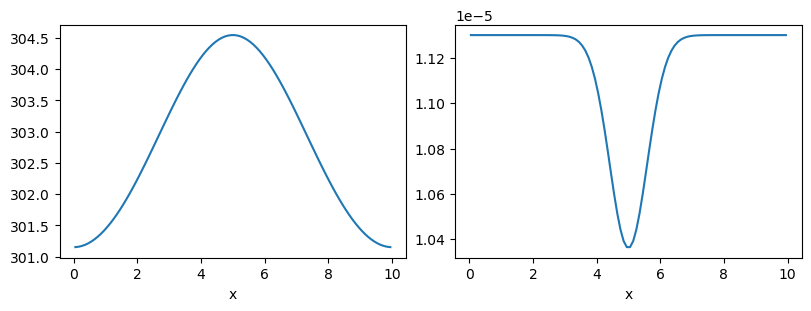

([<pde.tools.plotting.PlotReference at 0x773f7475a6c0>,
  <pde.tools.plotting.PlotReference at 0x773f7cc79f00>],)

In [281]:
result.plot() ,#konacno stanje

In [241]:
pde.movie(storage,filename=f"m1-11.mov")

  0%|          | 0/334 [00:00<?, ?it/s]

In [ ]:
zapisiM1("model1.txt")